In [51]:
from graph_tool.all import *
from tqdm import tqdm
from numba import njit

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import time

In [11]:
dfp=pd.read_csv('pam/examples/pop/ref/persons.csv').drop(['Unnamed: 0'], axis=1)
dfa=pd.read_csv('pam/examples/pop/ref/activities.csv').drop(['Unnamed: 0'], axis=1)

In [19]:
def filter_by_location(np_array):
    
    # Sort input array test w.r.t. first column that are IDs
    test_sorted = np_array[np_array[:,1].argsort()]

    # Convert the string IDs to numeric IDs
    locations = np.unique(test_sorted[:,1], return_inverse=False)
    # print('shape of numeric_ID {}'.format(numeric_ID.shape))

    # Get the indices where shifts (IDs change) occur
    _,cut_idx = np.unique(test_sorted[:,1],return_index=True)

    # Use the indices to split the input array into sub-arrays with common IDs
    return np.split(test_sorted,cut_idx)[1:]

@njit
def get_properties_potential_contact_network(test_case, purpose=None):
    
    # ID - LOCATION - START TIME - END TIME / PURPOSE
     
    act=np.zeros((3, 3))
    number_of_contacts_per_location=0
        
    for i in range(test_case.shape[0]-1): # loop through the activty-travel diaries
        row=test_case[i]
        pu=purpose[i] # origin
        
        rem=test_case[(i+1):]
        
        for k, pv in zip(rem, purpose[(i+1):]):  
            if k[0]!=row[0]: # if individuals are different
                
                if row[-1]<=k[2]: # no intersection
                    break
                else:
                    if pu>2:
                        pu=2
                
                    if pv>2:
                        pv=2
                    act[pu, pv]+=1
                    number_of_contacts_per_location+=1

    return act, number_of_contacts_per_location

In [20]:
out=filter_by_location(dfa[['person_id_gt','location_id','start_time','end_time','purpose']].astype(int).values)

In [21]:
## PROPERTIES OF THE POTENTIAL CONTACT NETWORK

list_of_group_contacts=[] # To store the amount of contacts generated after filtering per space/time at location ID k
list_of_adjacency_matrices=[]
nbloc=0

sttm=time.time()



with tqdm(total=len(out), position=0, leave=True) as pbar: 
    for k in out:
        locsize=len(np.unique(k[:,0]))
        if locsize>1:
            k_sorted=k[k[:, 2].argsort()]
            fo, nb_cnts=get_properties_potential_contact_network(k_sorted[:,0:-1], k_sorted[:,-1])
            list_of_group_contacts.append((locsize, nb_cnts))
            list_of_adjacency_matrices.append(fo)
            nbloc+=1
        pbar.update(1)
        
print(time.time()-sttm)

100%|██████████| 104601/104601 [00:01<00:00, 54700.41it/s]

1.923417091369629


In [25]:
np.asarray(list_of_adjacency_matrices).sum(axis=0)

array([[4.936659e+06, 9.609100e+04, 3.389690e+05],
       [1.568920e+05, 7.668490e+05, 3.288100e+04],
       [3.004600e+04, 1.823000e+03, 5.030130e+05]])

In [33]:
list_of_adjacency_matrices[1000]

array([[6., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [36]:
df=pd.DataFrame(np.asarray(list_of_group_contacts),columns=['size','cvol'])

In [45]:
ct=pd.crosstab(df['size'], df['cvol'])
ct

cvol,0,1,2,3,4,5,6,7,8,9,...,89551,102647,108921,114167,222629,240848,258811,298359,1034856,1055826
size,,,,,,,,,,,,,,,,,,,,,
2,14645,3980,880,190,56,25,8,3,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4601,2342,511,868,206,197,149,59,41,23,...,0,0,0,0,0,0,0,0,0,0
4,1424,1277,511,484,196,141,310,37,55,89,...,0,0,0,0,0,0,0,0,0,0
5,488,623,317,332,189,134,218,79,63,59,...,0,0,0,0,0,0,0,0,0,0
6,156,273,246,186,153,115,140,100,78,65,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [89]:
1024*1023

1047552

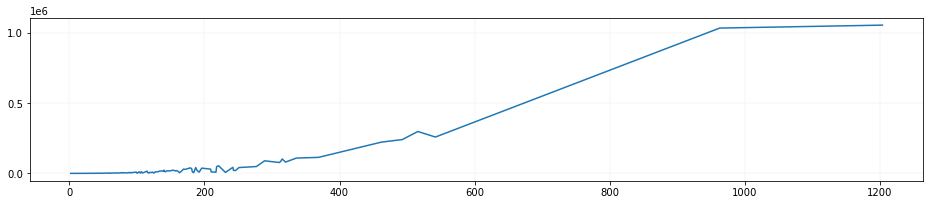

In [81]:
fig, ax=plt.subplots(figsize=(4*4,3))

data=[]
ydata=[]
xdata=[]

for k in range(1250):
    val=df[df['size']==k].cvol.values
    if val.shape[0]<1:
        data.append(0)
    else:
        data.append(val.mean())
        
        xdata.append(k)
        ydata.append(val.mean())
    
# ax.boxplot(data, showbox=True)
ax.grid(True, lw=0.1)
ax.set_yticks([0, 0.5e6, 1e6])
plt.plot(xdata, ydata)

plt.show()

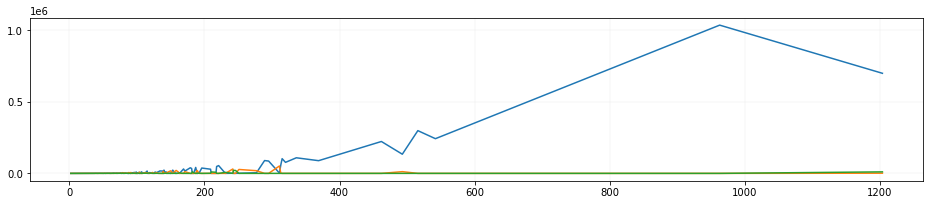

In [88]:
fig, ax=plt.subplots(figsize=(4*4,3))

for i in range(3):
    data=[]
    ydata=[]
    xdata=[]

    for k in range(1250):
        val=np.asarray(list_of_adjacency_matrices)[(df['size']==k).values, i, i]
        if val.shape[0]<1:
            data.append(0)
        else:
            data.append(val.mean())

            xdata.append(k)
            ydata.append(val.mean())

    # ax.boxplot(data, showbox=True)
    ax.grid(True, lw=0.1)
    ax.set_yticks([0, 0.5e6, 1e6])
    plt.plot(xdata, ydata)

plt.show()